In [1]:
import gc
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import MultiLabelBinarizer

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from keras.models import save_model, load_model

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Processando os dados

## Gerados com Penelope

In [3]:
files =  glob.glob("../dados_v[4-5]/*.dat")

In [4]:
len(files)

758

In [5]:
def le_performance_report(filename):
    # 164000
    # Performance report
    #   Random seeds:
    #   1800926990
    #   1275941380
    #   No. of histories simulated [N]:
    #            10000000.
    #   CPU time [t] (s):
    #    3.28417E+01
    #   Speed (histories/s):
    #    3.04491E+05
    #   Average uncertainty (above 1/2 max score) in % [uncert]:
    #    1.27128E-01
    #   Intrinsic efficiency [N*uncert^2]^-1:
    #    6.18758E-06
    #   Absolute efficiency [t*uncert^2]^-1:
    #    1.88406E+00
    
    with open(filename, "r") as f:
        linhas = f.readlines()
    try:
        return float(linhas[16400+7][1:])
    except:
        return float(linhas[16400+6][1:])

def carrega_dados(filename, n_particulas=1.0e07):
    data = {
        'Elow(eV)' : [],
        'Emiddle(eV)' : [],
        'counts(1/eV/hist)' : [],
        '+-2sigma':[],
        'nbin' : []
    }

    linha_de_dados = False
    with open(filename, "r") as f:
        for line in f:
            if line[0] == '#':
                linha_de_dados = False
            else:
                linha_de_dados = True

            if linha_de_dados:
                aux = line.split(' ')
                if len(aux) == 2:
                    break

                data['Elow(eV)'].append(np.fromstring(aux[2], dtype=np.float64, sep=',')[0])
                data['Emiddle(eV)'].append(np.fromstring(aux[4], dtype=np.float64, sep=',')[0])
                q = np.fromstring(aux[6], dtype=np.float64, sep=',')[0]
                data['counts(1/eV/hist)'].append(q)
                data['+-2sigma'].append(np.fromstring(aux[8], dtype=np.float64, sep=',')[0])
                nbin = np.fromstring(aux[9], dtype=np.int, sep=',')[0]
                data['nbin'].append(nbin)      

    df = pd.DataFrame.from_dict(data)
    df['counts'] = df['counts(1/eV/hist)'].values * n_particulas * 1 / ((df['Elow(eV)'].shift(-1).fillna(0) - df['Elow(eV)']) / df['nbin'])
    df['counts'] = df['counts']#.astype(np.uint8)
    df['counts'][0:20] = 0
    df['E'] = df['Elow(eV)'] / 1e3
    return df.loc[0:16383]

In [6]:
tempo_segundos = 0

for file_ in files:
    tempo_segundos += le_performance_report(file_)
    
print("Total de tempo de CPU utilizado: {0} dias".format(tempo_segundos / 60 / 60 / 24))

Total de tempo de CPU utilizado: 377.7199294814816 dias


In [7]:
energias_iniciais_multicanal = ['-1', '1', '250', '400', '150', '300', '0']
#energias_iniciais_multicanal = ['0-01.dat']
#energias_iniciais_multicanal = ['0-01.dat', '5-0.dat', '10-0.dat', '30-0.dat', '40-0.dat']
#energias_iniciais_multicanal = ['0-01.dat']

In [8]:
nomes_nuclideos = {
    'Am-241': 0,
    'Ba-133': 1,
    'Cd-109': 2,
    'Co-57': 3,
    'Co-60': 4,
    'Cs-137': 5,
    'Eu-152': 6,
    'Mn-54': 7,
    'Na-22': 8,
    'Pb-210': 9
}

binarizer = MultiLabelBinarizer()
binarizer.fit([list(nomes_nuclideos.keys())])
binarizer.classes_

array(['Am-241', 'Ba-133', 'Cd-109', 'Co-57', 'Co-60', 'Cs-137', 'Eu-152',
       'Mn-54', 'Na-22', 'Pb-210'], dtype=object)

In [9]:
# Cd-109_41cm_1-0e08estories_0-01.dat
dados_por_energia_inicial_multicanal = dict()

for energia_inicial_multicanal in energias_iniciais_multicanal:
    dados_por_energia_inicial_multicanal[energia_inicial_multicanal] = []
    
    for file_ in tqdm_notebook(files):
        if not file_.endswith('_'+energia_inicial_multicanal+'.dat'):
            continue
        
        partes = file_.split("/")[2].replace(".dat", "").split("_")
        nuclideo = partes[0]        
        distancia = partes[1]
        
        n_particulas_simulacao = float(partes[2].replace('estories','').replace('-','.'))
        
        # diferentes atividades
        for n_particulas in [1e3, 1e6, 1e9, 2e3, 2e6, 2e9, 3e3, 3e6, 3e9, n_particulas_simulacao]:
        
            dados_ = carrega_dados(file_, n_particulas)

            label_ = binarizer.transform([[nuclideo]])

            #Cria o label para o total de contagens do radionuclídeo
            #total_counts = np.zeros(label_.shape)
            #total_counts[0][np.argmax(label_)] = np.sum(dados_.counts.values)

            atividade = np.zeros(label_.shape)
            atividade[0][np.argmax(label_)] = n_particulas
            
            dados_por_energia_inicial_multicanal[energia_inicial_multicanal].append({
                'X' : dados_.counts.values,
                'n' : atividade,
                'y': label_,
                #'y_count' : total_counts,
                'd': distancia,
                'e': energia_inicial_multicanal
            })

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
a = 0
for k in dados_por_energia_inicial_multicanal:
    print(k, len(dados_por_energia_inicial_multicanal[k]))
    a += len(dados_por_energia_inicial_multicanal[k])
a

-1 400
1 1200
250 1190
400 1200
150 1200
300 1200
0 1190


7580

## Leituras experimentais da GRR

In [11]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [12]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [13]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

({'Am-241 - BG.IEC': 'Am-241',
  'Ba-133 - BG.IEC': 'Ba-133',
  'Cd-109 - BG.IEC': 'Cd-109',
  'Co-57 - BG.IEC': 'Co-57',
  'Co-60 - BG.IEC': 'Co-60',
  'Cs-137 - BG.IEC': 'Cs-137',
  'Eu-152 - BG.IEC': 'Eu-152',
  'Mn-54 - BG.IEC': 'Mn-54',
  'Na-22 - BG.IEC': 'Na-22',
  'Pb-210 - BG.IEC': 'Pb-210'},
 {'Am-241': 'Am-241 - BG.IEC',
  'Ba-133': 'Ba-133 - BG.IEC',
  'Cd-109': 'Cd-109 - BG.IEC',
  'Co-57': 'Co-57 - BG.IEC',
  'Co-60': 'Co-60 - BG.IEC',
  'Cs-137': 'Cs-137 - BG.IEC',
  'Eu-152': 'Eu-152 - BG.IEC',
  'Mn-54': 'Mn-54 - BG.IEC',
  'Na-22': 'Na-22 - BG.IEC',
  'Pb-210': 'Pb-210 - BG.IEC'},
 {0: 'Am-241',
  1: 'Ba-133',
  2: 'Cd-109',
  3: 'Co-57',
  4: 'Co-60',
  5: 'Cs-137',
  6: 'Eu-152',
  7: 'Mn-54',
  8: 'Na-22',
  9: 'Pb-210'},
 {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-22': 8,
  'Pb-210': 9})

In [14]:
#plt.plot(np.random.poisson(1e5, (128, 128)))
#plt.plot(np.random.normal(1, 0.1**0.5, (128, 128)))

In [15]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    if np.random.random() > 0.3:
        #increase de count rate by a random factor
        noisy += noisy * (1 + np.random.random())
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo


#def gera_imagem_combinada_experimental(dicionario_imagens, n_combinacoes=3):
#    assert n_combinacoes <= 10, "No máximo 10 combinações"
#    nuclei_idx = np.random.choice(10, n_combinacoes, replace=False).tolist()[0]
#    label = to_categorical(nuclei_idx, 10)
#    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[nuclei_idx]])], axis=0)
#    counts = to_categorical(nuclei_idx, 10)
#    counts[nuclei_idx] = np.sum(img)
#    
#    return img, label, counts

def gera_imagem_combinada_experimental(dicionario_imagens,
                                       n_combinacoes=1):
    
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    labels = np.sum([to_categorical(x, 10) for x in a], axis=0)
    noise_img = [add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a]
    img = np.sum(noise_img, axis=0)
    
    counts = np.zeros((10,))
    for idx, item in enumerate(a):
        counts[item] = np.sum(noise_img[idx])
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return img, labels, counts


# Gerando conjunto de treino e validação

## Com os dados experimentais

In [16]:
X = []
y = []
y_counts = []
ids = []

In [17]:
# gerando imagens com mais de um espectro
n_combinacoes = [1, 2, 3, 4]
for n_combinacao in n_combinacoes:
    for i in range(500):
        img, label, counts = gera_imagem_combinada_experimental(images, n_combinacao)
        X.append(img)
        y.append(label)
        y_counts.append(counts)
        ids.append({'tipo': 'experimental'})

In [18]:
len(X), len(y), len(y_counts), len(ids)

(2000, 2000, 2000, 2000)

## Com os dados gerados pelo PENELOPE

In [19]:
def gera_imagem_combinada_penelope(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"

    aux = np.random.choice(dicionario_imagens, n_combinacoes, replace=False)
    #print(aux)
    labels = np.sum([x['y'] for x in aux], axis=0)
    counts = np.sum([x['n'] for x in aux], axis=0)
    values = np.sum([x['X'] for x in aux], axis=0)
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    id_instancia = {'tipo': 'penelope_multiplo', 'meta': aux}
    
    return values, labels, counts, id_instancia

### Gera espectros com mais de um radionuclideo

Até 4 no mesmo espectro

In [20]:
n_combinacoes = [2, 3, 4]
novos_dados = dict()

for key in energias_iniciais_multicanal:
    novos_dados[key] = []
    for n_ in n_combinacoes:
        for i in range(800):
            values, labels, counts, id_instancia = gera_imagem_combinada_penelope(dados_por_energia_inicial_multicanal[key],
                                                  n_)
            novos_dados[key].append({'X' : values,
                                     'y': labels,
                                     'n': counts,
                                     'id': id_instancia})

In [21]:
for key in energias_iniciais_multicanal:
    for item in dados_por_energia_inicial_multicanal[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['n'][0])
        ids.append(item.get("id", {'tipo': 'penelope_original', 'meta': item}))

In [22]:
for key in energias_iniciais_multicanal:
    for item in novos_dados[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['n'][0])
        ids.append(item.get("id", {'tipo': 'penelope_original', 'meta': item}))

In [23]:
len(X), len(y), len(y_counts), len(ids)

(26380, 26380, 26380, 26380)

In [24]:
!rm -rf ./dados_v3_atividade
!mkdir ./dados_v3_atividade
np.save("./dados_v3_atividade/X.npy", [x.reshape((128,128,1)) for x in X])
np.save("./dados_v3_atividade/y.npy", y)
np.save("./dados_v3_atividade/y_counts.npy", y_counts)
np.save("./dados_v3_atividade/ids.npy", np.array(ids))

In [25]:
X = np.load("./dados_v3_atividade/X.npy")
y = np.load("./dados_v3_atividade/y.npy")
y_counts = np.load("./dados_v3_atividade/y_counts.npy")
ids = np.load("./dados_v3_atividade/ids.npy")

In [26]:
gc.collect()

0

# Modelo

## Dividindo os dados em treino e teste

In [27]:
#scaler = StandardScaler()
#scaler.fit(y_counts)

X_train, X_test, y_train, y_test = train_test_split(X, list(zip(y, np.log(np.array(y_counts) + 1))),
                                                    test_size=0.30,
                                                    random_state=42)

In [28]:
ids_train, ids_test  = train_test_split(ids,
                                       test_size=0.30,
                                       random_state=42)

In [29]:
len(X_train), len(y_train), len(ids_train), len(X_test), len(y_test), len(ids_test)

(18466, 18466, 18466, 7914, 7914, 7914)

In [30]:
from keras.utils import Sequence

In [31]:
class EspectraSequence(Sequence):

    def __init__(self, x_set, y_set, y_set_count, batch_size):
        self.x, self.y, self.y_set_count = x_set, y_set, y_set_count
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_count = self.y_set_count[idx * self.batch_size:(idx + 1) * self.batch_size]

        y_ = {'predictions_nuclei': np.array(batch_y, dtype=np.float32),
              'predictions_counts': np.array(batch_y_count)}
        
        return np.array([x.reshape((128, 128, 1)) for x in batch_x]), y_

In [32]:
s = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

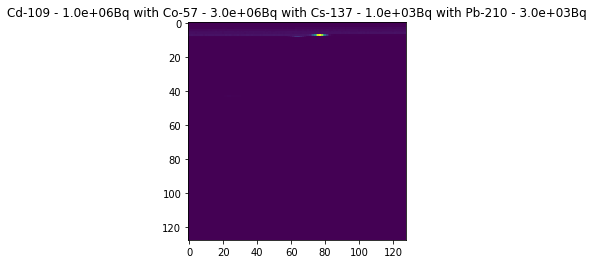

In [33]:
a, b = s[2]
c = b['predictions_counts']
b = b['predictions_nuclei']
plt.imshow(a[0].reshape((128, 128)))
title_data = list(zip(binarizer.inverse_transform(np.array([b[0]]))[0], np.exp(c[0])[np.array([b[0]]).astype(np.bool)[0]]))
plt.title(" with ".join(["{} - {:.1e}Bq".format(x[0], x[1]) for x in title_data]))
plt.show()

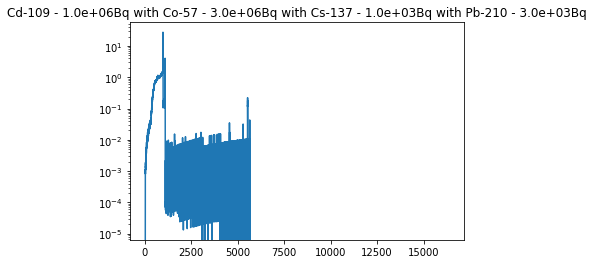

In [34]:
title_data = list(zip(binarizer.inverse_transform(np.array([b[0]]))[0], np.exp(c[0])[np.array([b[0]]).astype(np.bool)[0]]))
plt.title(" with ".join(["{} - {:.1e}Bq".format(x[0], x[1]) for x in title_data]))
plt.plot(a[0].reshape(-1))
plt.yscale("log")
plt.show()

In [35]:
def accuracy_score_wrapper(label, pred):
    threshold = .95
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

def my_accuracy_score(label, pred):
    metric_value = tf.compat.v1.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [36]:
K.clear_session()
import keras
vgg_model = VGG19(include_top=False,
                  weights=None,
                  input_shape=(128, 128, 1),
                  classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)
pred_nuclei = keras.layers.Dense(10, activation='sigmoid', name="predictions_nuclei")(x)

x1 = keras.layers.Flatten()(vgg_model.output)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
pred_counts = keras.layers.Dense(10, activation=None, name="predictions_counts")(x1)

#se a previsão do modelo for menor que zero, a gente zera a saída, afinal de contas
#não existe atividade 0 bq :P
#pred_counts = keras.layers.Lambda(lambda x: tf.where(x < 0, tf.zeros_like(x), x),
#                                 name="predictions_counts")(pred_counts)

model = keras.models.Model(vgg_model.input, [pred_nuclei, pred_counts])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
_____________________________________

In [37]:
learning_rate = 1e-5
epochs = 250
batch_size = 8
steps_per_epoch = len(X_train) // batch_size + 1
validation_steps = len(X_test) // batch_size + 1

In [38]:
opt = SGD(lr=learning_rate,
          nesterov=False,
          momentum=0.9) # keras.optimizers.RMSprop(0.001)

model.compile(optimizer=Adam(lr=1e-4),
              loss={
                  'predictions_nuclei': 'binary_crossentropy',
                  'predictions_counts': 'mean_squared_error'
              },
              metrics={
                  'predictions_nuclei': [my_accuracy_score, 'accuracy'],
                  'predictions_counts': ['mean_squared_error', 'mean_absolute_error']
              }
             )

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [39]:
!nvidia-smi

Thu Aug 13 08:46:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   40C    P5    12W / 180W |      0MiB /  8117MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [40]:
!rm -rf ./logsv3_atividade
!mkdir ./logsv3_atividade

In [41]:
from keras.callbacks import LearningRateScheduler

In [42]:
import math
def step_decay(epoch):
    initial_lrate = 1e-5
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [43]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='VGG-19-Adam-classificacao-regressao-PENELOPE-v3_atividade.hdf5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [44]:
gerador_treino = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=5)

lrate = LearningRateScheduler(step_decay)

tb = keras.callbacks.TensorBoard(
    log_dir='./logsv3_atividade',
    histogram_freq=0,
    #batch_size=32,
    write_graph=True,
    #batch_gen=gerador_validacao,
    #nb_steps=validation_steps,
    update_freq='epoch')

callbacks = [es, tb, model_checkpoint_callback]#, lrate]

hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=2,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)


Instructions for updating:
Use tf.cast instead.
Epoch 1/250
 - 319s - loss: 24.9973 - predictions_nuclei_loss: 0.4003 - predictions_counts_loss: 24.5970 - predictions_nuclei_my_accuracy_score: 0.1282 - predictions_nuclei_acc: 0.8572 - predictions_counts_mean_squared_error: 24.5970 - predictions_counts_mean_absolute_error: 3.1359 - val_loss: 12.4723 - val_predictions_nuclei_loss: 0.2646 - val_predictions_counts_loss: 12.2077 - val_predictions_nuclei_my_accuracy_score: 0.3170 - val_predictions_nuclei_acc: 0.9139 - val_predictions_counts_mean_squared_error: 12.2077 - val_predictions_counts_mean_absolute_error: 2.0079
Epoch 2/250
 - 317s - loss: 10.7382 - predictions_nuclei_loss: 0.2345 - predictions_counts_loss: 10.5037 - predictions_nuclei_my_accuracy_score: 0.3780 - predictions_nuclei_acc: 0.9225 - predictions_counts_mean_squared_error: 10.5037 - predictions_counts_mean_absolute_error: 1.7843 - val_loss: 9.0438 - val_predictions_nuclei_loss: 0.2103 - val_predictions_counts_loss: 8.8335 

Epoch 15/250
 - 317s - loss: 4.9951 - predictions_nuclei_loss: 0.1434 - predictions_counts_loss: 4.8517 - predictions_nuclei_my_accuracy_score: 0.6079 - predictions_nuclei_acc: 0.9534 - predictions_counts_mean_squared_error: 4.8517 - predictions_counts_mean_absolute_error: 0.9812 - val_loss: 5.2647 - val_predictions_nuclei_loss: 0.1561 - val_predictions_counts_loss: 5.1086 - val_predictions_nuclei_my_accuracy_score: 0.5982 - val_predictions_nuclei_acc: 0.9530 - val_predictions_counts_mean_squared_error: 5.1086 - val_predictions_counts_mean_absolute_error: 1.0076
Epoch 16/250
 - 317s - loss: 5.0529 - predictions_nuclei_loss: 0.1429 - predictions_counts_loss: 4.9101 - predictions_nuclei_my_accuracy_score: 0.6082 - predictions_nuclei_acc: 0.9534 - predictions_counts_mean_squared_error: 4.9101 - predictions_counts_mean_absolute_error: 0.9904 - val_loss: 5.4611 - val_predictions_nuclei_loss: 0.1575 - val_predictions_counts_loss: 5.3036 - val_predictions_nuclei_my_accuracy_score: 0.5959 - va

In [103]:
1+1

2

In [45]:
save_model(model, 'VGG-19-Adam-classificacao-regressao-PENELOPE-v3_atividade_last_epoch.hdf5')

In [104]:
model = load_model('VGG-19-Adam-classificacao-regressao-PENELOPE-v3_atividade_last_epoch.hdf5',
                  custom_objects={'my_accuracy_score': my_accuracy_score})

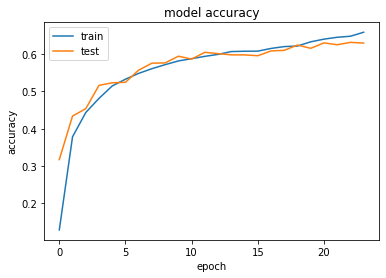

In [47]:
plt.plot(hist.history['predictions_nuclei_my_accuracy_score'])
plt.plot(hist.history['val_predictions_nuclei_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

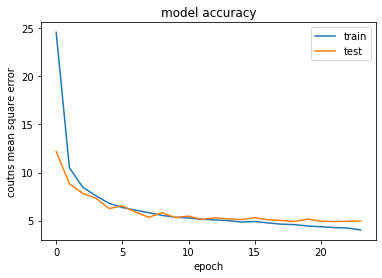

In [48]:
plt.plot(hist.history['predictions_counts_mean_squared_error'])
plt.plot(hist.history['val_predictions_counts_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('coutns mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

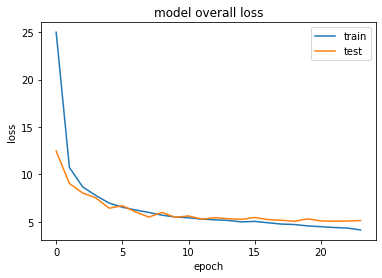

In [49]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model overall loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

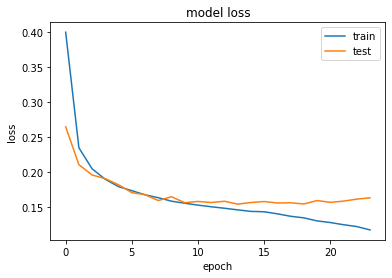

In [50]:
plt.plot(hist.history['predictions_nuclei_loss'])
plt.plot(hist.history['val_predictions_nuclei_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Fine Tunning das partes finais

# Validando nos espectros criados com Penelope

In [51]:
from keras.utils.vis_utils import plot_model

In [52]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

280


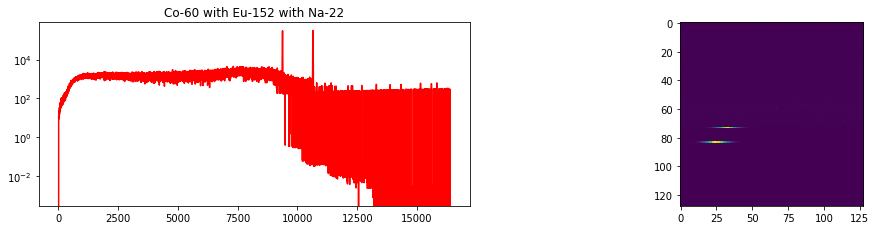

In [53]:
gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=1)
idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
print(idx_)
x_, aux_ = gerador_validacao[idx_]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 0
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [54]:
preds = model.predict(np.array([x_[idx].reshape((128, 128, 1))]))

In [55]:
df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   #'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'nuclei_counts': np.exp(preds[1][0]) - 1,
                   #'real_counts': scaler.inverse_transform(y_counts[idx])
                   'real_counts': np.exp(y_counts[idx]) - 1
                  })
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,10.53,1.77,0.00
1,Ba-133,10.52,2.93,0.00
2,Cd-109,4.09,-0.57,0.00
3,Co-57,5.04,0.88,0.00
4,Co-60,99.99,"1,406,901,120.00","3,000,000,000.00"
5,Cs-137,3.49,-0.07,0.00
6,Eu-152,6.77,1.43,"1,000,000.00"
7,Mn-54,8.06,0.59,0.00
8,Na-22,98.43,"2,287,608.00","3,000,000.00"
9,Pb-210,5.46,0.33,0.00


In [56]:
# Criar uma massa de dados simulando com papel ao invés de água
# Corrigir as contagens na entrada pela eficiência da similação
# Re-treinar

# Validando nos espectros experimentais

In [57]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [58]:
arquivos = ['Am-241 - BG.IEC',
            'Ba-133 - BG.IEC',
            'Cd-109 - BG.IEC',
            'Co-57 - BG.IEC',
            'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC',
            'Eu-152 - BG.IEC',
            'Mn-54 - BG.IEC',
            'Na-22 - BG.IEC',
            'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


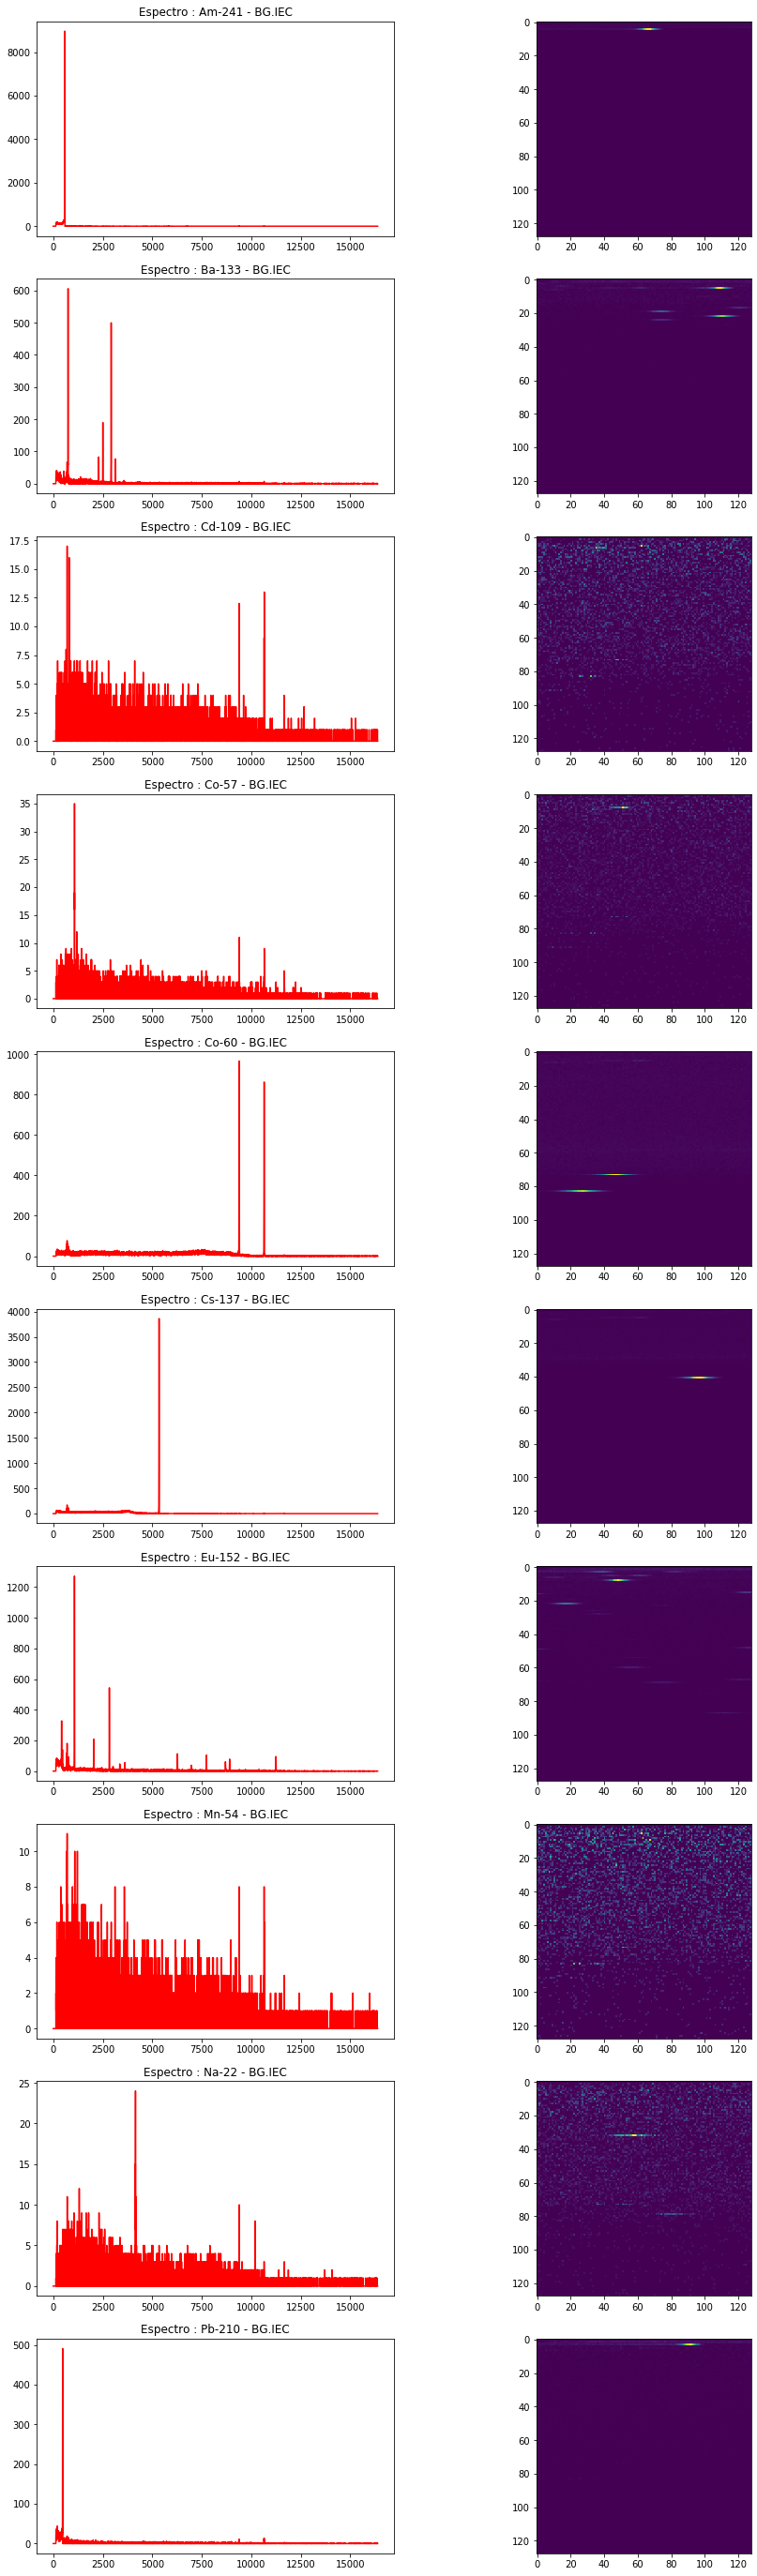

In [59]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [60]:
preds = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]) - 1,
                   'real_counts': np.sum(images['Am-241'])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,99.82,"528,724.44","141,596.00"
1,Ba-133,0.00,0.48,"141,596.00"
2,Cd-109,0.15,-0.00,"141,596.00"
3,Co-57,0.05,0.25,"141,596.00"
4,Co-60,0.00,0.04,"141,596.00"
5,Cs-137,0.00,0.38,"141,596.00"
6,Eu-152,0.00,0.03,"141,596.00"
7,Mn-54,0.17,-0.01,"141,596.00"
8,Na-22,0.26,0.90,"141,596.00"
9,Pb-210,0.30,1.02,"141,596.00"


In [61]:
validation_nuclei = 'Ba-133'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,1.04,"35,319.00"
1,Ba-133,99.96,"43,294.89","35,319.00"
2,Cd-109,0.04,1.33,"35,319.00"
3,Co-57,0.00,0.95,"35,319.00"
4,Co-60,0.00,0.96,"35,319.00"
5,Cs-137,0.00,1.11,"35,319.00"
6,Eu-152,0.00,0.96,"35,319.00"
7,Mn-54,0.00,0.75,"35,319.00"
8,Na-22,0.00,0.90,"35,319.00"
9,Pb-210,0.01,0.89,"35,319.00"


In [62]:
validation_nuclei = 'Cd-109'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.17,1.48,"7,195.00"
1,Ba-133,0.02,1.48,"7,195.00"
2,Cd-109,86.23,"1,015.81","7,195.00"
3,Co-57,0.06,0.84,"7,195.00"
4,Co-60,0.00,1.10,"7,195.00"
5,Cs-137,0.01,1.03,"7,195.00"
6,Eu-152,0.00,1.18,"7,195.00"
7,Mn-54,0.01,0.83,"7,195.00"
8,Na-22,0.03,1.27,"7,195.00"
9,Pb-210,2.62,2.16,"7,195.00"


In [63]:
validation_nuclei = 'Co-57'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,2.64,1.18,"7,323.00"
1,Ba-133,0.71,1.45,"7,323.00"
2,Cd-109,1.17,0.93,"7,323.00"
3,Co-57,98.08,"2,309.43","7,323.00"
4,Co-60,0.00,1.14,"7,323.00"
5,Cs-137,0.16,1.24,"7,323.00"
6,Eu-152,0.00,1.12,"7,323.00"
7,Mn-54,0.38,1.35,"7,323.00"
8,Na-22,0.00,1.11,"7,323.00"
9,Pb-210,6.20,1.70,"7,323.00"


In [64]:
validation_nuclei = 'Co-60'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.55,0.95,"155,643.00"
1,Ba-133,0.25,1.27,"155,643.00"
2,Cd-109,7.35,1.53,"155,643.00"
3,Co-57,1.03,1.43,"155,643.00"
4,Co-60,100.00,"1,520,216.88","155,643.00"
5,Cs-137,0.14,0.95,"155,643.00"
6,Eu-152,0.62,1.01,"155,643.00"
7,Mn-54,0.66,1.02,"155,643.00"
8,Na-22,0.19,1.04,"155,643.00"
9,Pb-210,0.69,1.09,"155,643.00"


In [65]:
validation_nuclei = 'Cs-137'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,0.92,"188,461.00"
1,Ba-133,0.00,1.03,"188,461.00"
2,Cd-109,0.01,0.86,"188,461.00"
3,Co-57,0.00,1.01,"188,461.00"
4,Co-60,0.00,1.04,"188,461.00"
5,Cs-137,99.99,"459,320.81","188,461.00"
6,Eu-152,0.00,1.09,"188,461.00"
7,Mn-54,0.00,1.04,"188,461.00"
8,Na-22,0.00,1.00,"188,461.00"
9,Pb-210,0.53,1.75,"188,461.00"


In [66]:
validation_nuclei = 'Eu-152'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,0.90,"94,419.00"
1,Ba-133,0.00,1.22,"94,419.00"
2,Cd-109,0.09,1.10,"94,419.00"
3,Co-57,0.01,0.65,"94,419.00"
4,Co-60,0.00,1.07,"94,419.00"
5,Cs-137,0.00,1.26,"94,419.00"
6,Eu-152,100.00,"312,134.59","94,419.00"
7,Mn-54,0.07,1.20,"94,419.00"
8,Na-22,0.01,1.10,"94,419.00"
9,Pb-210,0.03,1.70,"94,419.00"


In [67]:
validation_nuclei = 'Mn-54'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.27,0.85,"7,159.00"
1,Ba-133,0.05,0.92,"7,159.00"
2,Cd-109,0.38,1.75,"7,159.00"
3,Co-57,0.12,1.00,"7,159.00"
4,Co-60,0.35,1.28,"7,159.00"
5,Cs-137,0.16,1.84,"7,159.00"
6,Eu-152,0.01,1.18,"7,159.00"
7,Mn-54,99.99,"9,894.09","7,159.00"
8,Na-22,0.04,1.01,"7,159.00"
9,Pb-210,2.77,1.45,"7,159.00"


In [68]:
validation_nuclei = 'Na-22'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,2.32,1.13,"7,965.00"
1,Ba-133,1.67,1.50,"7,965.00"
2,Cd-109,1.73,0.96,"7,965.00"
3,Co-57,2.05,1.22,"7,965.00"
4,Co-60,0.01,0.88,"7,965.00"
5,Cs-137,0.86,1.22,"7,965.00"
6,Eu-152,0.13,1.20,"7,965.00"
7,Mn-54,0.69,1.09,"7,965.00"
8,Na-22,100.00,"12,387.50","7,965.00"
9,Pb-210,3.58,1.34,"7,965.00"


In [69]:
validation_nuclei = 'Pb-210'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,1.05,"19,650.00"
1,Ba-133,0.00,1.45,"19,650.00"
2,Cd-109,0.11,1.03,"19,650.00"
3,Co-57,0.00,1.29,"19,650.00"
4,Co-60,0.00,0.97,"19,650.00"
5,Cs-137,0.00,1.54,"19,650.00"
6,Eu-152,0.00,1.26,"19,650.00"
7,Mn-54,0.00,0.83,"19,650.00"
8,Na-22,0.00,0.99,"19,650.00"
9,Pb-210,100.00,"44,602.43","19,650.00"


## Fonte triplice de calibração

In [70]:
dados = []

with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df_triplice = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

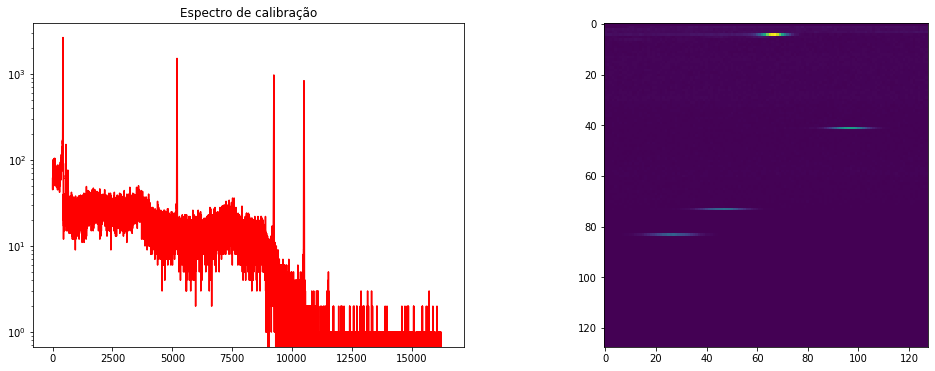

In [71]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro de calibração")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [72]:
shift_ = 0
dados = df_triplice.counts.shift(shift_).fillna(0).values

preds = model.predict(np.array([dados.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(dados)})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,99.89,"54,272.01","276,428.00"
1,Ba-133,0.04,0.97,"276,428.00"
2,Cd-109,0.23,0.60,"276,428.00"
3,Co-57,0.08,1.12,"276,428.00"
4,Co-60,100.00,"227,986.75","276,428.00"
5,Cs-137,99.98,"186,136.83","276,428.00"
6,Eu-152,0.33,1.20,"276,428.00"
7,Mn-54,3.23,1.31,"276,428.00"
8,Na-22,0.03,1.03,"276,428.00"
9,Pb-210,0.47,2.00,"276,428.00"


# Validando a atividade com um espectro simulado

In [112]:
df_am241 = carrega_dados('../dados_v5/Am-241_46cm_1-0e08estories_-1.dat', 1e8)

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


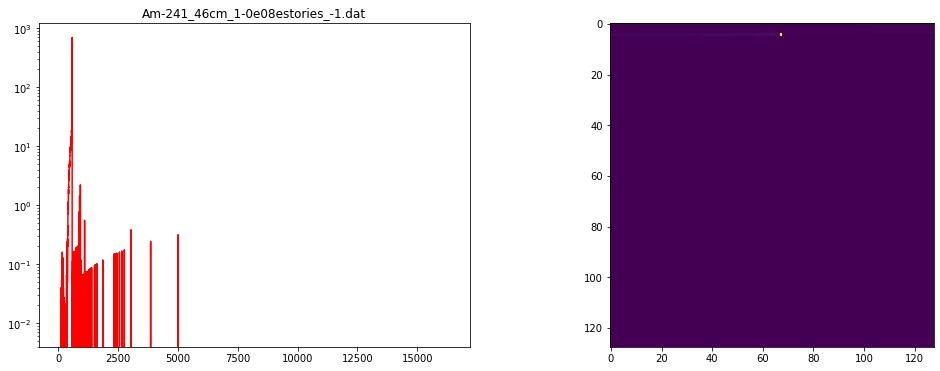

In [113]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_am241['nbin'], df_am241.counts.values, 'r')
axarr[0].set_title("Am-241_46cm_1-0e08estories_-1.dat")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(df_am241.counts.values).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [114]:
preds = model.predict(np.array([df_am241.counts.values.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(df_am241.counts.values)})
df = df.set_index('radionuclideo')
df

,nuclei_score,nuclei_counts,real_counts
radionuclideo,,,
Am-241,99.98,"72,254,080.00","2,203.19"
Ba-133,3.71,7.72,"2,203.19"
Cd-109,4.95,1.46,"2,203.19"
Co-57,2.25,1.22,"2,203.19"
Co-60,0.00,0.95,"2,203.19"
Cs-137,0.13,1.50,"2,203.19"
Eu-152,0.00,1.07,"2,203.19"
Mn-54,0.00,0.96,"2,203.19"
Na-22,0.00,1.12,"2,203.19"


In [79]:
from scipy.signal import find_peaks

In [80]:
largura = 350

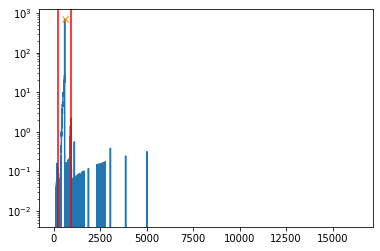

In [81]:
peaks, _ = find_peaks(df_am241.counts.values, prominence=2e1)
plt.plot(df_am241.counts.values)
plt.plot(peaks, df_am241.counts[peaks], "x")
plt.plot(np.zeros_like(df_am241.counts), "--", color="gray")

plt.axvline(peaks[0]-largura, 0, 1e4, label='pyplot vertical line', color="red")
plt.axvline(peaks[0]+largura, 0, 1e4, label='pyplot vertical line', color="red")

plt.yscale("log")
plt.show()

In [82]:
values = []
for idx, peak in enumerate(peaks):
    print(idx)
    data_aux = df_am241[peak-(largura+1*idx):peak+(largura+1*idx)]
    values.append(np.trapz(data_aux['counts'], data_aux['nbin']))
values, np.sum(values)

0


([2193.5404807415443], 2193.5404807415443)

In [83]:
def print_formatado(x):
    return "{:4.4e}".format(x)

In [84]:
eff = np.sum(values) / 1e8
print_formatado(eff)

'2.1935e-05'

In [85]:
atividade = df.loc['Am-241'].nuclei_counts / eff
print_formatado(atividade), atividade / 1e8

('3.2939e+12', 32939.4787259973)

## Para Co-60

In [115]:
df_co60 = carrega_dados('../dados_v5/Co-60_56cm_1-0e08estories_-1.dat', 1e8)

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


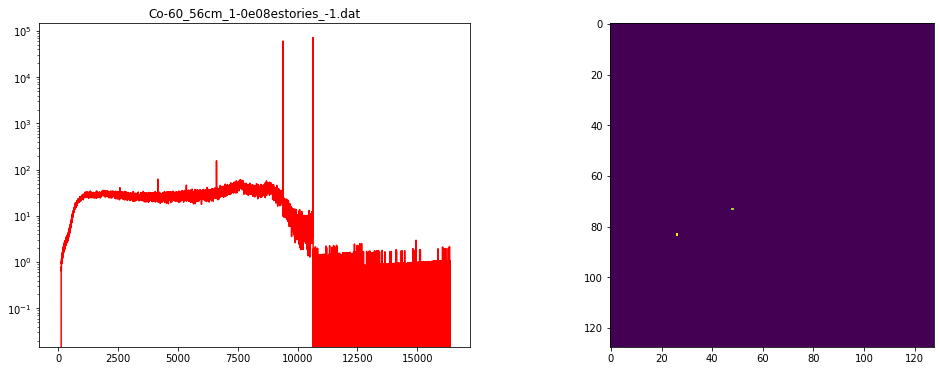

In [116]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_co60['nbin'], df_co60.counts.values, 'r')
axarr[0].set_title("Co-60_56cm_1-0e08estories_-1.dat")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(df_co60.counts.values).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [89]:
(85_955_360 / 1e8 - 1) * 100

-14.044639999999998

In [117]:
preds = model.predict(np.array([df_co60.counts.values.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(df_co60.counts.values)})
df = df.set_index("radionuclideo")
df

,nuclei_score,nuclei_counts,real_counts
radionuclideo,,,
Am-241,3.82,1.41,"413,587.11"
Ba-133,5.60,1.67,"413,587.11"
Cd-109,8.70,2.55,"413,587.11"
Co-57,1.73,1.17,"413,587.11"
Co-60,100.00,"137,522,464.00","413,587.11"
Cs-137,7.45,2.15,"413,587.11"
Eu-152,1.69,1.28,"413,587.11"
Mn-54,22.61,2.54,"413,587.11"
Na-22,1.82,1.12,"413,587.11"


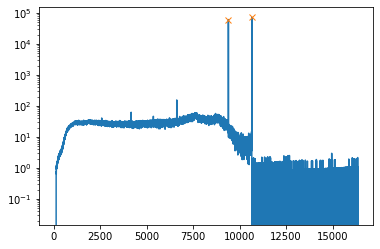

In [118]:
peaks, _ = find_peaks(df_co60.counts.values, prominence=2e3)
plt.plot(df_co60.counts.values)
plt.plot(peaks, df_co60.counts[peaks], "x")
plt.plot(np.zeros_like(df_co60.counts), "--", color="gray")
plt.yscale("log")
plt.show()

In [92]:
largura = 450
values = []
for idx, peak in enumerate(peaks):
    print(idx)
    data_aux = df_co60[peak-(largura+1*idx):peak+(largura+1*idx)]
    values.append(np.trapz(data_aux['counts'], data_aux['nbin']))
values, np.sum(values)

eff = np.mean(np.array(values)) / 1e8
eff, values

0
1


(0.0007730151506341052, [79198.69070473113, 75404.33942208992])

In [93]:
values, np.array(values) / 1e8

([79198.69070473113, 75404.33942208992], array([0.00079199, 0.00075404]))

In [94]:
atividade = df.loc['Co-60']['nuclei_counts'] / eff
atividade, atividade / 1e8

(177903969782.727, 1779.03969782727)

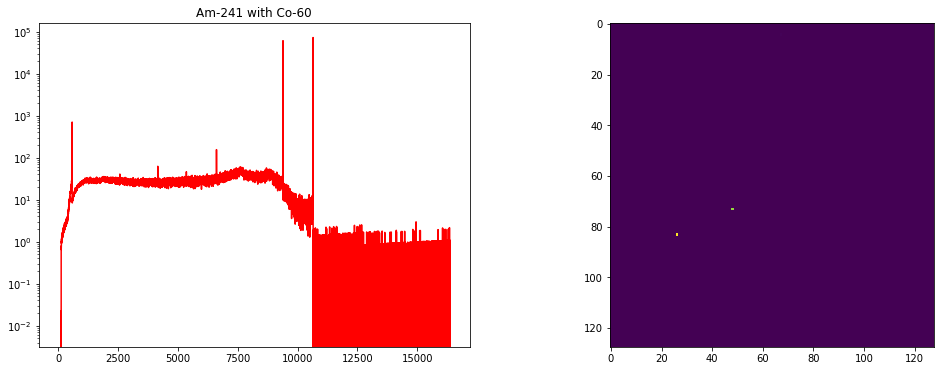

In [119]:
df_am241_co60 = df_am241.counts + df_co60.counts

f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_am241['nbin'], df_am241_co60.values, 'r')
axarr[0].set_title("Am-241 with Co-60")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(df_am241_co60.values).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [120]:
preds = model.predict(np.array([df_am241_co60.values.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_activity': np.exp(preds[1][0]),
                   'real_activity': [1e8, 0, 0, 0, 1e8, 0, 0, 0, 0, 0],
                   'diff': np.exp(preds[1][0]) / np.array([1e8, 0, 0, 0, 1e8, 0, 0, 0, 0, 0])
                  })
df = df.set_index("radionuclideo")
df

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


,nuclei_score,nuclei_activity,real_activity,diff
radionuclideo,,,,
Am-241,99.99,"94,616,744.00","100,000,000.00",0.95
Ba-133,10.38,2.11,0.00,inf
Cd-109,3.64,2.15,0.00,inf
Co-57,5.87,9.18,0.00,inf
Co-60,100.00,"110,316,040.00","100,000,000.00",1.10
Cs-137,1.12,1.18,0.00,inf
Eu-152,0.85,0.93,0.00,inf
Mn-54,13.80,1.31,0.00,inf
Na-22,2.23,1.49,0.00,inf


In [121]:
(94_616_744 / 1e8 - 1)*100, (110_316_040 / 1e8 - 1) * 100

(-5.383256000000003, 10.316039999999994)

# Fine tunning das últimas camadas

In [98]:
K.clear_session()

In [99]:
model = load_model('VGG-19-Adam-classificacao-regressao-PENELOPE-v2_atividade.hdf5',
                  custom_objects={'my_accuracy_score': my_accuracy_score})

for layer in model.layers:
    layer.trainable = False
    
model.layers[-7].trainable = True
model.layers[-3].trainable = True
model.layers[-5].trainable = True
model.layers[-1].trainable = True

#for layer in model.layers:
#    print(layer.name, layer.trainable)

In [100]:
model.compile(optimizer=Adam(lr=1e-7),
              loss={
                  #'predictions_nuclei': 'binary_crossentropy',
                  'predictions_counts': 'mean_squared_error'
              },
              metrics={
                  #'predictions_nuclei': [my_accuracy_score, 'accuracy'],
                  'predictions_counts': ['mean_squared_error', 'mean_absolute_error']
              }
             )

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Output "predictions_nuclei" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "predictions_nuclei" during training.
  


In [101]:
gerador_treino = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)


In [102]:
hist_fine = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=200,
                           verbose=2,
                           #callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)

Epoch 1/200
 - 128s - loss: 5.0618 - predictions_counts_loss: 5.0618 - predictions_counts_mean_squared_error: 5.0618 - predictions_counts_mean_absolute_error: 0.9893 - val_loss: 4.9570 - val_predictions_counts_loss: 4.9570 - val_predictions_counts_mean_squared_error: 4.9570 - val_predictions_counts_mean_absolute_error: 0.9830
Epoch 2/200
 - 126s - loss: 5.0472 - predictions_counts_loss: 5.0472 - predictions_counts_mean_squared_error: 5.0472 - predictions_counts_mean_absolute_error: 0.9820 - val_loss: 4.9435 - val_predictions_counts_loss: 4.9435 - val_predictions_counts_mean_squared_error: 4.9435 - val_predictions_counts_mean_absolute_error: 0.9769
Epoch 3/200
 - 126s - loss: 5.0354 - predictions_counts_loss: 5.0354 - predictions_counts_mean_squared_error: 5.0354 - predictions_counts_mean_absolute_error: 0.9767 - val_loss: 4.9323 - val_predictions_counts_loss: 4.9323 - val_predictions_counts_mean_squared_error: 4.9323 - val_predictions_counts_mean_absolute_error: 0.9721
Epoch 4/200
 - 1

Epoch 26/200
 - 127s - loss: 4.9165 - predictions_counts_loss: 4.9165 - predictions_counts_mean_squared_error: 4.9165 - predictions_counts_mean_absolute_error: 0.9373 - val_loss: 4.8264 - val_predictions_counts_loss: 4.8264 - val_predictions_counts_mean_squared_error: 4.8264 - val_predictions_counts_mean_absolute_error: 0.9355
Epoch 27/200
 - 126s - loss: 4.9134 - predictions_counts_loss: 4.9134 - predictions_counts_mean_squared_error: 4.9134 - predictions_counts_mean_absolute_error: 0.9364 - val_loss: 4.8239 - val_predictions_counts_loss: 4.8239 - val_predictions_counts_mean_squared_error: 4.8239 - val_predictions_counts_mean_absolute_error: 0.9349
Epoch 28/200
 - 126s - loss: 4.9103 - predictions_counts_loss: 4.9103 - predictions_counts_mean_squared_error: 4.9103 - predictions_counts_mean_absolute_error: 0.9356 - val_loss: 4.8215 - val_predictions_counts_loss: 4.8215 - val_predictions_counts_mean_squared_error: 4.8215 - val_predictions_counts_mean_absolute_error: 0.9343
Epoch 29/200


Epoch 51/200
 - 126s - loss: 4.8537 - predictions_counts_loss: 4.8537 - predictions_counts_mean_squared_error: 4.8537 - predictions_counts_mean_absolute_error: 0.9253 - val_loss: 4.7788 - val_predictions_counts_loss: 4.7788 - val_predictions_counts_mean_squared_error: 4.7788 - val_predictions_counts_mean_absolute_error: 0.9257
Epoch 52/200
 - 126s - loss: 4.8517 - predictions_counts_loss: 4.8517 - predictions_counts_mean_squared_error: 4.8517 - predictions_counts_mean_absolute_error: 0.9247 - val_loss: 4.7773 - val_predictions_counts_loss: 4.7773 - val_predictions_counts_mean_squared_error: 4.7773 - val_predictions_counts_mean_absolute_error: 0.9255
Epoch 53/200
 - 126s - loss: 4.8496 - predictions_counts_loss: 4.8496 - predictions_counts_mean_squared_error: 4.8496 - predictions_counts_mean_absolute_error: 0.9246 - val_loss: 4.7759 - val_predictions_counts_loss: 4.7759 - val_predictions_counts_mean_squared_error: 4.7759 - val_predictions_counts_mean_absolute_error: 0.9253
Epoch 54/200


KeyboardInterrupt: 

In [105]:
dados = [x['meta'] for x in ids if x['tipo'] == 'penelope_multiplo' and len(x['meta']) == 2 
 and (x['meta'][0]['y'] == np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])).all()
 and (x['meta'][1]['y'] == np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])).all()
 and (x['meta'][0]['n'] == np.array([[1e8, 0, 0, 0, 0, 0, 0, 0, 0, 0]])).all()
 #and (x['meta'][1]['n'] == np.array([[0, 0, 0, 0, 1e8, 0, 0, 0, 0, 0]])).all()
]

In [ ]:
dados[0][0]['X'] + dados[0][1]['X']

In [ ]:
dados[0][0]['n'] + dados[0][1]['n']

In [106]:
preds = model.predict(np.array([(dados[0][0]['X'] + dados[0][1]['X']).reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_activity': np.exp(preds[1][0]),
                   'real_activity': (dados[0][0]['n'] + dados[0][1]['n'])[0],
                   'diff': np.exp(preds[1][0]) / np.array((dados[0][0]['n'] + dados[0][1]['n'])[0])
                  })
df = df.set_index("radionuclideo")
df

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


,nuclei_score,nuclei_activity,real_activity,diff
radionuclideo,,,,
Am-241,100.00,"107,255,720.00","100,000,000.00",1.07
Ba-133,5.02,2.81,0.00,inf
Cd-109,0.11,0.51,0.00,inf
Co-57,0.01,0.45,0.00,inf
Co-60,100.00,"1,271.12","2,000.00",0.64
Cs-137,0.00,1.39,0.00,inf
Eu-152,0.00,1.04,0.00,inf
Mn-54,0.00,0.60,0.00,inf
Na-22,0.00,1.18,0.00,inf


In [111]:
(107_255_720 / 1e8 -1) * 100, (1_271 / 2_000 - 1) *100

(7.25572000000001, -36.45)